In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import math
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load Dataset
file_link = 'https://drive.google.com/file/d/1jIZuJ6opm82OfpBgI2EXYLAvRPv8-Jcr/view?usp=drive_link'
id = file_link.split("/")[-2]
new_link = f'https://drive.google.com/uc?id={id}'
df = pd.read_csv(new_link)
df.head(5)

,age,gender,job_type,daily_social_media_time,social_platform_preference,number_of_notifications,work_hours_per_day,perceived_productivity_score,actual_productivity_score,stress_level,sleep_hours,screen_time_before_sleep,breaks_during_work,uses_focus_apps,has_digital_wellbeing_enabled,coffee_consumption_per_day,days_feeling_burnout_per_month,weekly_offline_hours,job_satisfaction_score
0,56,Male,Unemployed,4.180940,Facebook,61,6.753558,8.040464,7.291555,4.0,5.116546,0.419102,8,False,False,4,11,21.927072,6.336688
1,46,Male,Health,3.249603,Twitter,59,9.169296,5.063368,5.165093,7.0,5.103897,0.671519,7,True,True,2,25,0.000000,3.412427
2,32,Male,Finance,NaN,Twitter,57,7.910952,3.861762,3.474053,4.0,8.583222,0.624378,0,True,False,3,17,10.322044,2.474944
3,60,Female,Unemployed,NaN,Facebook,59,6.355027,2.916331,1.774869,6.0,6.052984,1.204540,1,False,False,0,4,23.876616,1.733670
4,25,Male,IT,NaN,Telegram,66,6.214096,8.868753,NaN,7.0,5.405706,1.876254,1,False,True,1,30,10.653519,9.693060


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             30000 non-null  int64  
 1   gender                          30000 non-null  object 
 2   job_type                        30000 non-null  object 
 3   daily_social_media_time         27235 non-null  float64
 4   social_platform_preference      30000 non-null  object 
 5   number_of_notifications         30000 non-null  int64  
 6   work_hours_per_day              30000 non-null  float64
 7   perceived_productivity_score    28386 non-null  float64
 8   actual_productivity_score       27635 non-null  float64
 9   stress_level                    28096 non-null  float64
 10  sleep_hours                     27402 non-null  float64
 11  screen_time_before_sleep        27789 non-null  float64
 12  breaks_during_work              

In [ ]:
df.isnull().sum()

,0
age,0
gender,0
job_type,0
daily_social_media_time,2765
social_platform_preference,0
number_of_notifications,0
work_hours_per_day,0
perceived_productivity_score,1614
actual_productivity_score,2365
stress_level,1904


In [ ]:
df.shape

(30000, 19)

In [ ]:
# Handeling NULL Values :
df = df.dropna(subset=["actual_productivity_score"]).reset_index(drop=True)
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "bool"]).columns.tolist()
num_cols = [col for col in num_cols if col != "actual_productivity_score"]

num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 age                               0
gender                            0
job_type                          0
daily_social_media_time           0
social_platform_preference        0
number_of_notifications           0
work_hours_per_day                0
perceived_productivity_score      0
actual_productivity_score         0
stress_level                      0
sleep_hours                       0
screen_time_before_sleep          0
breaks_during_work                0
uses_focus_apps                   0
has_digital_wellbeing_enabled     0
coffee_consumption_per_day        0
days_feeling_burnout_per_month    0
weekly_offline_hours              0
job_satisfaction_score            0
dtype: int64


In [ ]:
df.shape

(27635, 19)

In [ ]:
# Boolean data handled
df["uses_focus_apps"] = df["uses_focus_apps"].astype(int)
df["has_digital_wellbeing_enabled"] = df["has_digital_wellbeing_enabled"].astype(int)

In [ ]:
# Label Encoding
le = LabelEncoder()
for col in ["gender", "job_type", "social_platform_preference"]:
    df[col] = le.fit_transform(df[col])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27635 entries, 0 to 27634
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             27635 non-null  float64
 1   gender                          27635 non-null  int64  
 2   job_type                        27635 non-null  int64  
 3   daily_social_media_time         27635 non-null  float64
 4   social_platform_preference      27635 non-null  int64  
 5   number_of_notifications         27635 non-null  float64
 6   work_hours_per_day              27635 non-null  float64
 7   perceived_productivity_score    27635 non-null  float64
 8   actual_productivity_score       27635 non-null  float64
 9   stress_level                    27635 non-null  float64
 10  sleep_hours                     27635 non-null  float64
 11  screen_time_before_sleep        27635 non-null  float64
 12  breaks_during_work              

In [ ]:
# Outlier detection:
num_cols = df.drop(columns=["actual_productivity_score"]).columns.tolist()
print(f"Total numeric feature columns: {len(num_cols)}")
print(num_cols)

outlier_summary = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary[col] = outliers

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier_Count'])
outlier_df['Outlier_%'] = 100 * outlier_df['Outlier_Count'] / len(df)
outlier_df.sort_values("Outlier_%", ascending=False)

Total numeric feature columns: 18
['age', 'gender', 'job_type', 'daily_social_media_time', 'social_platform_preference', 'number_of_notifications', 'work_hours_per_day', 'perceived_productivity_score', 'stress_level', 'sleep_hours', 'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps', 'has_digital_wellbeing_enabled', 'coffee_consumption_per_day', 'days_feeling_burnout_per_month', 'weekly_offline_hours', 'job_satisfaction_score']


,Outlier_Count,Outlier_%
has_digital_wellbeing_enabled,6828,24.707798
daily_social_media_time,301,1.089198
number_of_notifications,244,0.882938
screen_time_before_sleep,184,0.665822
coffee_consumption_per_day,118,0.426995
weekly_offline_hours,106,0.383572
work_hours_per_day,88,0.318437
age,0,0.000000
gender,0,0.000000
job_type,0,0.000000


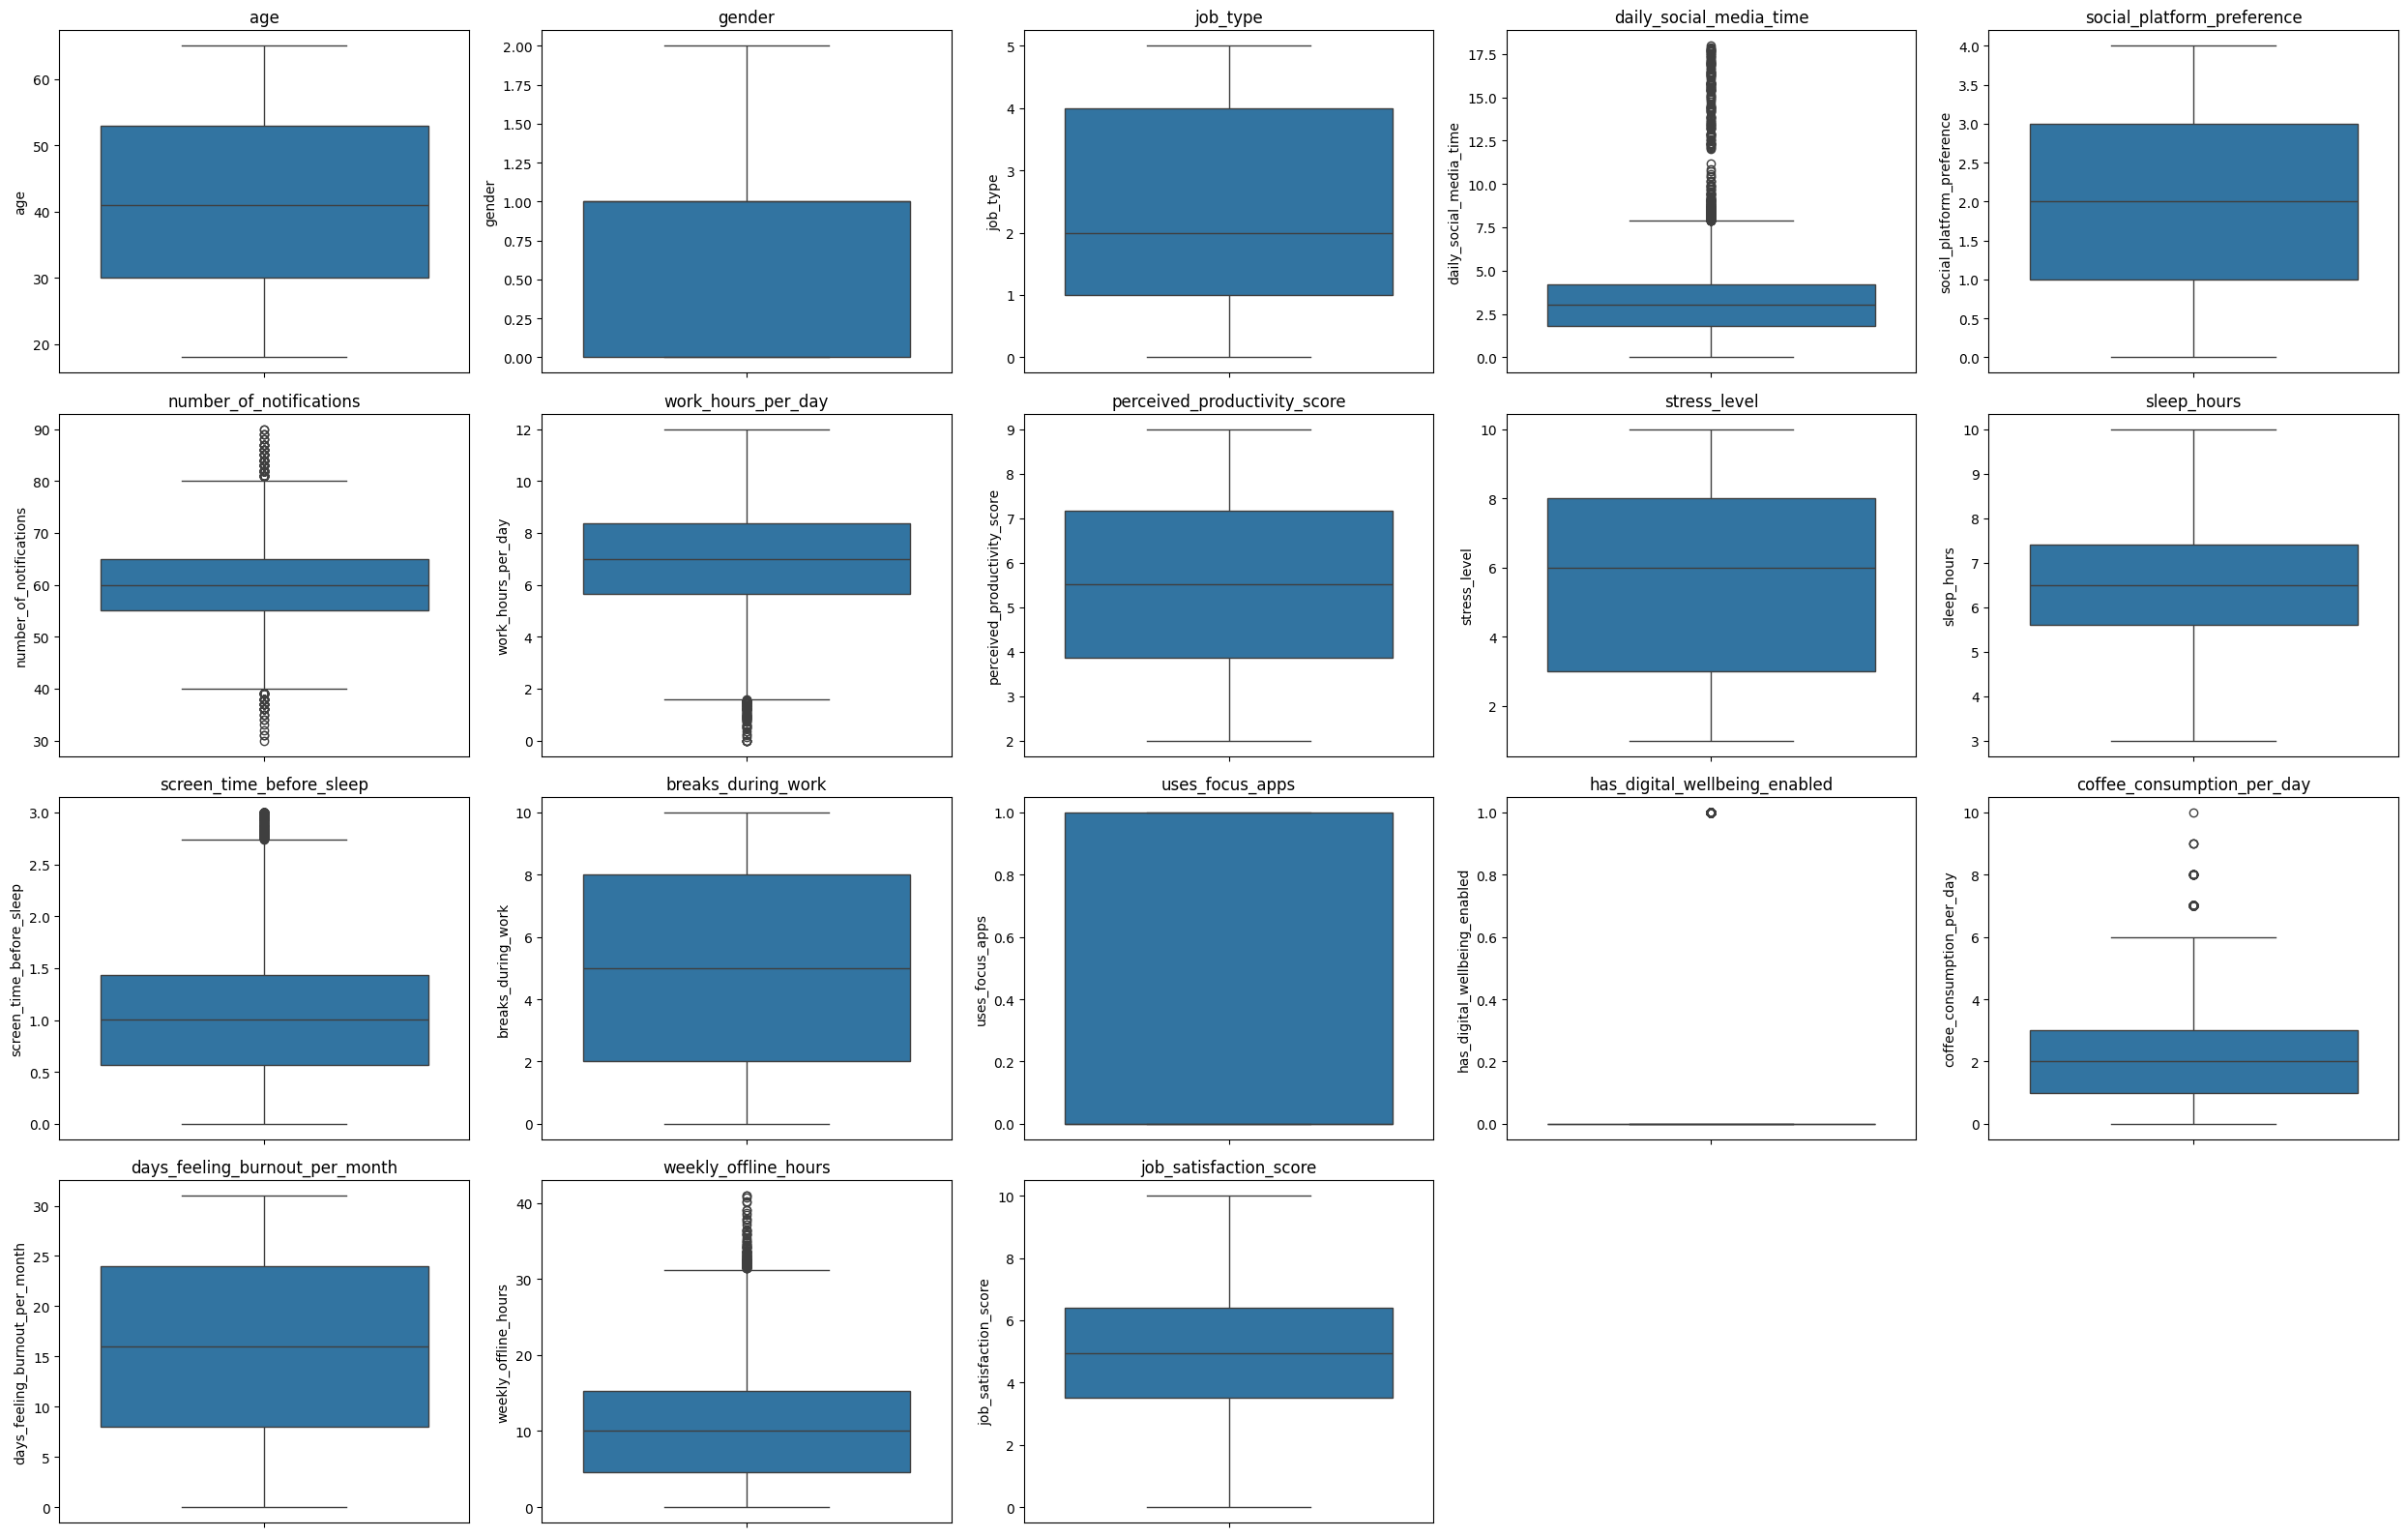

In [ ]:
n = len(num_cols)
ncols = 5
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)

for j in range(i+1, nrows*ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
#Capping  outliers :
def cap_outliers(df, cols, lower=0.01, upper=0.99):
    df_capped = df.copy()
    for col in cols:
        low_val, high_val = df[col].quantile([lower, upper])
        df_capped[col] = np.clip(df[col], low_val, high_val)
    return df_capped

feature_cols = [c for c in df.columns if c != "actual_productivity_score"]
df_capped = cap_outliers(df, feature_cols)

print("Outliers capped at 1st and 99th percentile.")

Outliers capped at 1st and 99th percentile.


Correlation with actual_productivity_score:

actual_productivity_score         1.000000
perceived_productivity_score      0.938980
job_satisfaction_score            0.842236
age                               0.010575
social_platform_preference        0.008488
job_type                          0.005182
screen_time_before_sleep          0.002376
coffee_consumption_per_day        0.001156
stress_level                      0.000990
number_of_notifications           0.000457
work_hours_per_day               -0.000113
uses_focus_apps                  -0.001023
breaks_during_work               -0.004203
weekly_offline_hours             -0.004839
gender                           -0.006516
has_digital_wellbeing_enabled    -0.006856
sleep_hours                      -0.007516
daily_social_media_time          -0.010484
days_feeling_burnout_per_month   -0.011001
Name: actual_productivity_score, dtype: float64


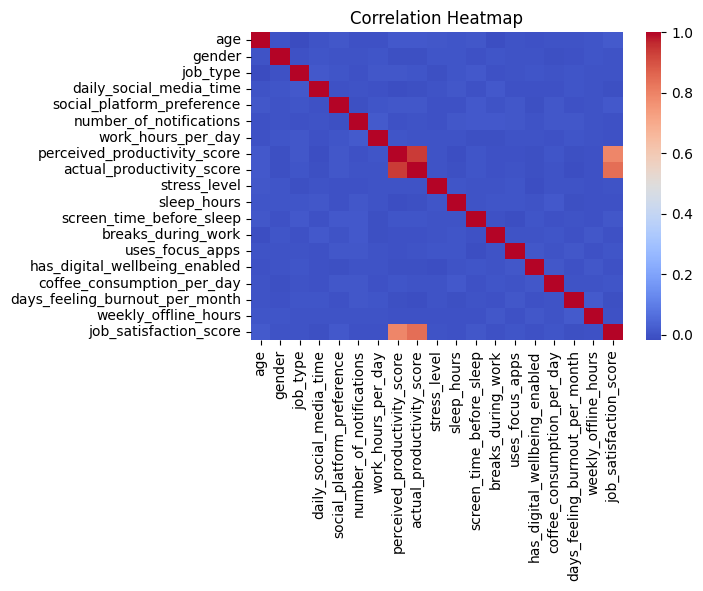

In [ ]:
#Correlation :
corr = df.corr()
target_corr = corr["actual_productivity_score"].sort_values(ascending=False)

print("Correlation with actual_productivity_score:\n")
print(target_corr)

plt.figure(figsize=(6,4))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

RandomForest Feature Importances:

perceived_productivity_score      0.890426
job_satisfaction_score            0.051957
work_hours_per_day                0.006084
sleep_hours                       0.006014
weekly_offline_hours              0.005464
screen_time_before_sleep          0.005451
daily_social_media_time           0.005447
age                               0.004894
number_of_notifications           0.004809
days_feeling_burnout_per_month    0.004630
breaks_during_work                0.003193
stress_level                      0.003082
job_type                          0.002221
coffee_consumption_per_day        0.002181
social_platform_preference        0.001990
gender                            0.000893
has_digital_wellbeing_enabled     0.000636
uses_focus_apps                   0.000627
dtype: float64


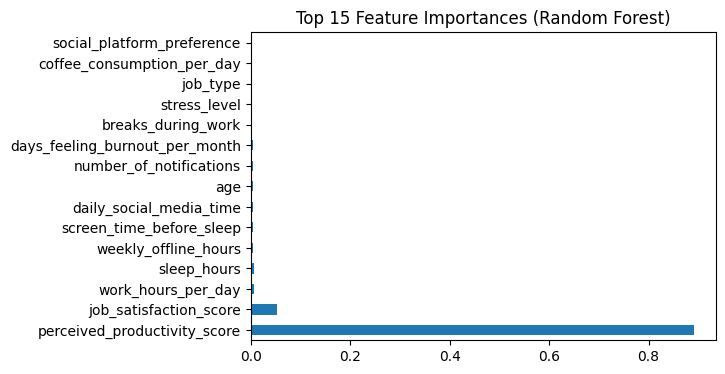

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop(columns=["actual_productivity_score"])
y = df["actual_productivity_score"]

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("RandomForest Feature Importances:\n")
print(importances)

plt.figure(figsize=(6,4))
importances.head(15).plot(kind="barh")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

In [ ]:
#Feature Engineering :
df["social_time_per_work_hour"] = df["daily_social_media_time"] / (df["work_hours_per_day"] + 1e-6)
df["sleep_deficit"] = 8 - df["sleep_hours"]
df["stress_burnout_interaction"] = df["stress_level"] * df["days_feeling_burnout_per_month"]

print(df[["social_time_per_work_hour", "sleep_deficit", "stress_burnout_interaction"]].head())

   social_time_per_work_hour  sleep_deficit  stress_burnout_interaction
0                   0.619072       2.883454                        44.0
1                   0.354400       2.896103                       175.0
2                   0.382764      -0.583222                        68.0
3                   0.476477       1.947016                        24.0
4                   0.235261       2.484749                        10.0


RandomForest Feature Importances with Engineered Features:

perceived_productivity_score      0.890585
job_satisfaction_score            0.051243
work_hours_per_day                0.005339
weekly_offline_hours              0.005027
screen_time_before_sleep          0.004967
number_of_notifications           0.004504
age                               0.004413
stress_burnout_interaction        0.004238
social_time_per_work_hour         0.003775
daily_social_media_time           0.003718
days_feeling_burnout_per_month    0.003502
sleep_hours                       0.002937
sleep_deficit                     0.002922
breaks_during_work                0.002757
stress_level                      0.002365
job_type                          0.002000
coffee_consumption_per_day        0.001994
social_platform_preference        0.001778
gender                            0.000825
uses_focus_apps                   0.000564
has_digital_wellbeing_enabled     0.000547
dtype: float64


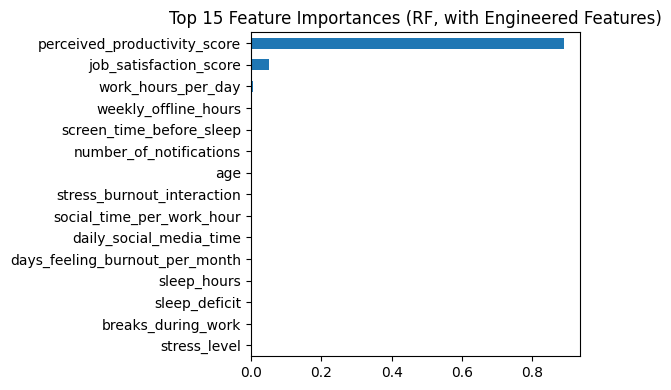

In [ ]:
# RandomForest Feature Importance
X = df.drop(columns=["actual_productivity_score"])
y = df["actual_productivity_score"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("RandomForest Feature Importances with Engineered Features:\n")
print(importances)
plt.figure(figsize=(6,4))
importances.head(15).sort_values().plot(kind="barh")
plt.title("Top 15 Feature Importances (RF, with Engineered Features)")
plt.tight_layout()
plt.show()


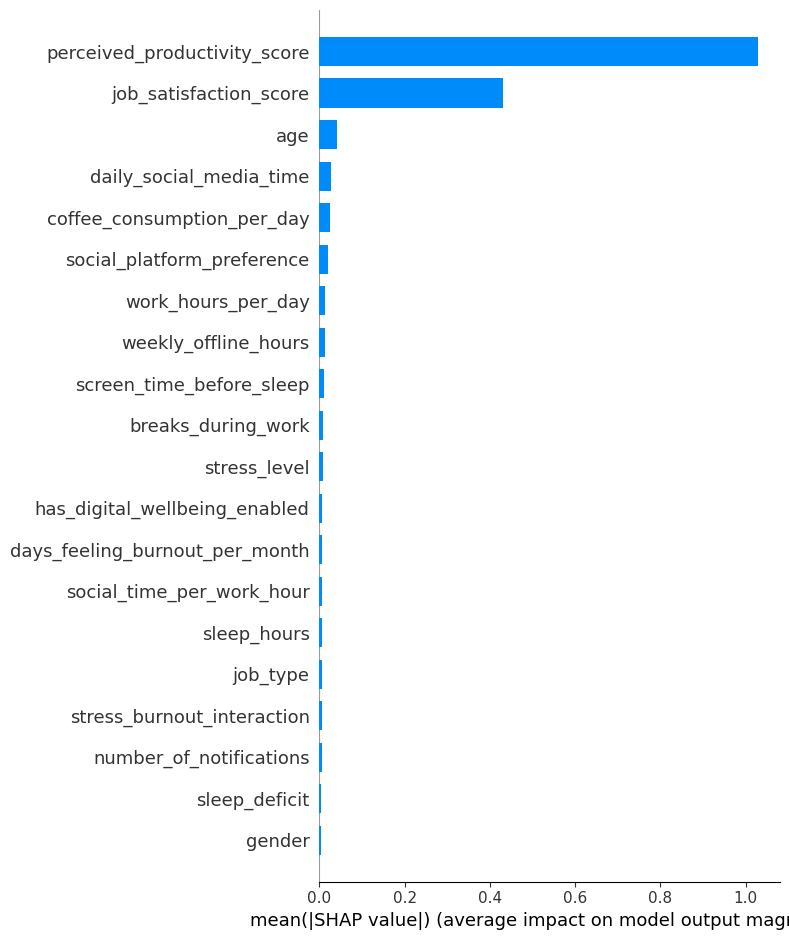

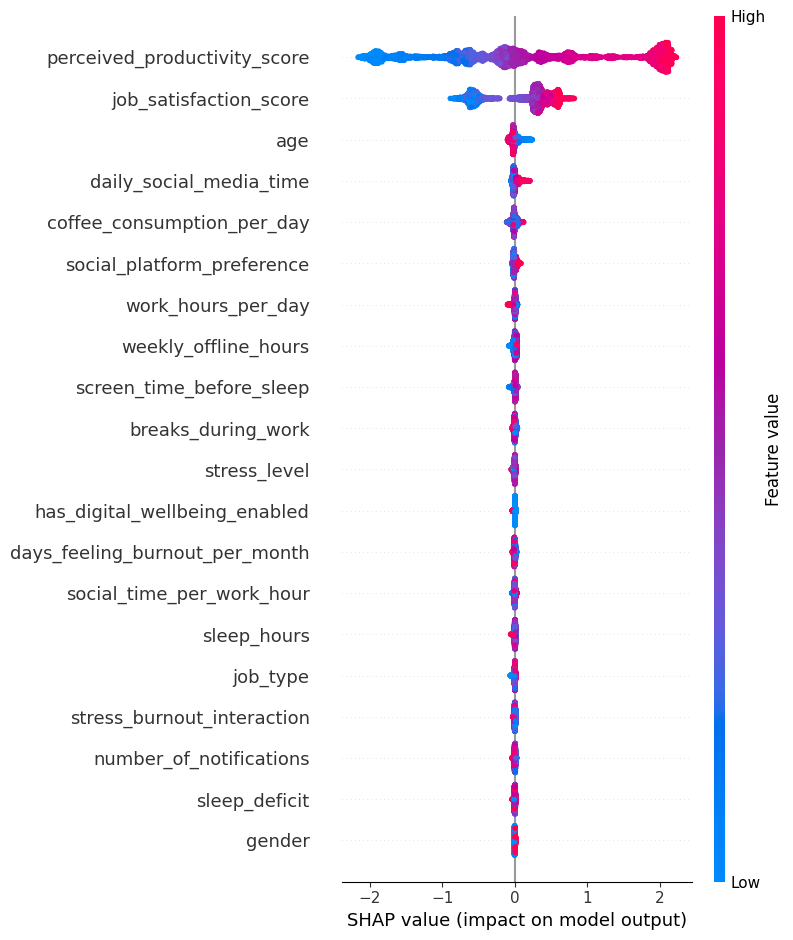

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import shap
X_train_small = X_train.sample(n=min(100, len(X_train)), random_state=42)
y_train_small = y_train.loc[X_train_small.index]

rf_small = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
rf_small.fit(X_train_small, y_train_small)

X_shap = X_test.sample(n=min(5000, len(X_test)), random_state=42)
explainer = shap.TreeExplainer(rf_small, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_shap, check_additivity=False)

shap.summary_plot(shap_values, X_shap, plot_type="bar")
print('')
shap.summary_plot(shap_values, X_shap)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb

def convert_ranges_to_numeric(value):
    if isinstance(value, str):
        if '–' in value:
            start, end = value.split('–')
            return (int(start) + int(end)) / 2
    return value

X = X.applymap(convert_ranges_to_numeric)
X = X.fillna(X.mean())

y = df["actual_productivity_score"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    return {"Model": name, "R²": r2, "RMSE": rmse, "MAE": mae}

lin = LinearRegression()
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
xgb_model = xgb.XGBRegressor(n_estimators=300, random_state=42, verbosity=0)
lgb_model = lgb.LGBMRegressor(n_estimators=300, random_state=42, verbose=-1)

results = []
results.append(evaluate_model(lin, "Linear Regression"))
results.append(evaluate_model(rf, "Random Forest"))
results.append(evaluate_model(xgb_model, "XGBoost"))
results.append(evaluate_model(lgb_model, "LightGBM"))

results_df = pd.DataFrame(results)
print(results_df)


               Model        R²      RMSE       MAE
0  Linear Regression  0.905752  0.582695  0.428623
1      Random Forest  0.924462  0.521661  0.401924
2            XGBoost  0.914157  0.556105  0.429498
3           LightGBM  0.924686  0.520886  0.401280


In [ ]:
# Subgroup fairness metrics:
def subgroup_metrics(df, model, X_test, y_test, group_col, mapping=None):
    results = []
    for group in df.loc[X_test.index, group_col].unique():
        idx = df.loc[X_test.index][df[group_col] == group].index
        y_true = y_test.loc[idx]
        y_pred = model.predict(X_test.loc[idx])
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        label = mapping[group] if mapping else group
        results.append({"Group": label, "RMSE": rmse, "MAE": mae})
    return pd.DataFrame(results)
gender_map = {
    0: "Male",
    1: "Female",
    2: "Other"
}
job_type_map = {
    0: "Engineer",
    1: "Teacher",
    2: "Doctor",
    3: "Student",
    4: "Manager",
    5: "Other Job"
}
fairness_gender = subgroup_metrics(df, rf, X_test, y_test, "gender", mapping=gender_map)
print("Fairness by Gender:\n", fairness_gender, "\n")

fairness_job = subgroup_metrics(df, rf, X_test, y_test, "job_type", mapping=job_type_map)
print("Fairness by Job Type:\n", fairness_job, "\n")

bins = [0, 20, 30, 40, 50, 60, 100]
labels = ["<20", "20–29", "30–39", "40–49", "50–59", "60+"]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)
fairness_age_group = subgroup_metrics(df, rf, X_test, y_test, "age_group")
print("Fairness by Age Group:\n", fairness_age_group, "\n")

Fairness by Gender:
     Group      RMSE       MAE
0  Female  0.506850  0.397682
1    Male  0.534898  0.404436
2   Other  0.533016  0.421671 

Fairness by Job Type:
        Group      RMSE       MAE
0   Engineer  0.507529  0.390086
1     Doctor  0.542218  0.409115
2  Other Job  0.519479  0.409529
3    Student  0.514775  0.394162
4    Manager  0.521701  0.401704
5    Teacher  0.524122  0.406678 

Fairness by Age Group:
    Group      RMSE       MAE
0  20–29  0.527184  0.402901
1  50–59  0.519243  0.396065
2    60+  0.539514  0.401862
3  40–49  0.522592  0.412450
4  30–39  0.513902  0.397342
5    <20  0.505636  0.398205 

